In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

from skimage.metrics import peak_signal_noise_ratio

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
if dev is 'cuda':
  dtype = torch.cuda.FloatTensor
else:
  dtype = torch.FloatTensor
print(f'Using device {device}')

Using device cpu


In [3]:
from models import *
from models.unet import *
# Change IMAGE to jet for jet image or snail for snail image
IMAGE = 'snail'

if IMAGE == 'snail':
    net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1], weight_std=1./30).type(dtype)
elif IMAGE == 'jet':
    net = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30).type(dtype)
else:
    assert False
net.to(device)
print(net)

UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvBlock(
        (pad): 

In [4]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 747803


# Regular Training (no input optimization or adversarial training)

In [5]:
from utils import *
from input_gen import *

reg_noise_std = 1./30.
fname_snail = 'data/denoising/snail.jpg'
fname_jet = 'data/denoising/F16_GT.png'
fname = fname_snail if IMAGE == 'snail' else fname_jet
use_noise = False if IMAGE == 'snail' else True
img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
target_img = img_tr
if use_noise:
    target_noisy_img, _ = add_noise_to_tensor(target_img, 'normal', std=reg_noise_std)
else:
    target_noisy_img = target_img
target_noisy_img = target_noisy_img.unsqueeze(dim=0).to(device)
net_input = get_noise(*img_tr.shape, method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()
if reg_noise_std > 0:
        net_input = net_input + (noise.normal_() * reg_noise_std)

C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


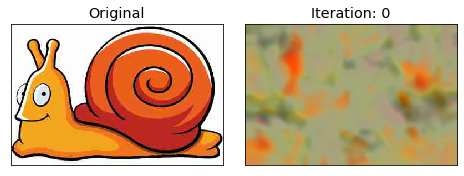

Iteration  100   Loss = 0.027851   PSNR noisy = 15.551625   PSNR gt = 15.551625 
Iteration  200   Loss = 0.013731   PSNR noisy = 18.623064   PSNR gt = 18.623064 


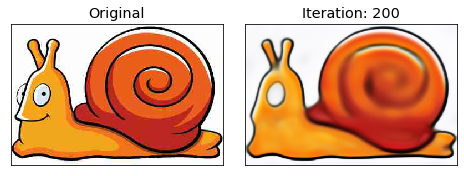

Iteration  300   Loss = 0.007952   PSNR noisy = 20.995302   PSNR gt = 20.995302 
Iteration  400   Loss = 0.005895   PSNR noisy = 22.295359   PSNR gt = 22.295359 


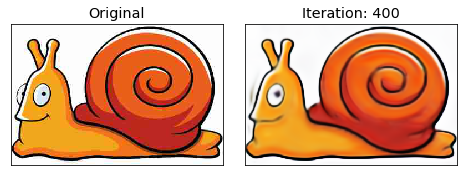

Iteration  500   Loss = 0.004624   PSNR noisy = 23.350155   PSNR gt = 23.350155 
Iteration  600   Loss = 0.004325   PSNR noisy = 23.640045   PSNR gt = 23.640045 


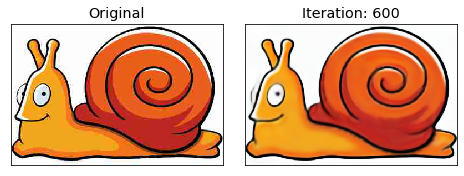

Iteration  700   Loss = 0.003279   PSNR noisy = 24.842204   PSNR gt = 24.842204 
Iteration  800   Loss = 0.003300   PSNR noisy = 24.815389   PSNR gt = 24.815389 


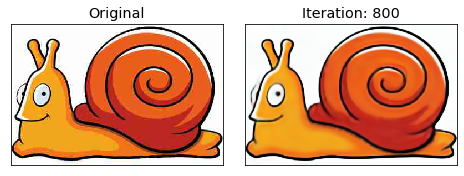

Iteration  900   Loss = 0.002638   PSNR noisy = 25.786468   PSNR gt = 25.786468 
Iteration  1000   Loss = 0.003027   PSNR noisy = 25.189331   PSNR gt = 25.189331 


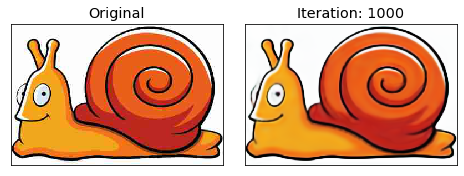

Iteration  1100   Loss = 0.002594   PSNR noisy = 25.860437   PSNR gt = 25.860437 
Iteration  1200   Loss = 0.002515   PSNR noisy = 25.994161   PSNR gt = 25.994161 


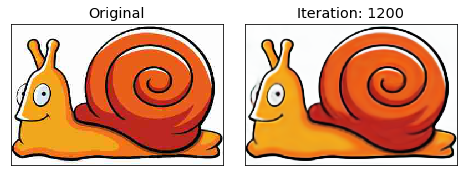

Iteration  1300   Loss = 0.002275   PSNR noisy = 26.429511   PSNR gt = 26.429511 
Iteration  1400   Loss = 0.002256   PSNR noisy = 26.465757   PSNR gt = 26.465757 


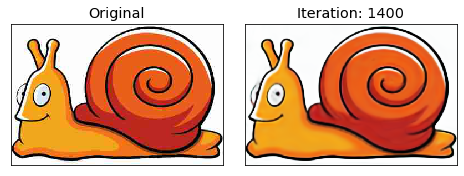

Iteration  1500   Loss = 0.002194   PSNR noisy = 26.587707   PSNR gt = 26.587707 
Iteration  1600   Loss = 0.002139   PSNR noisy = 26.697799   PSNR gt = 26.697799 


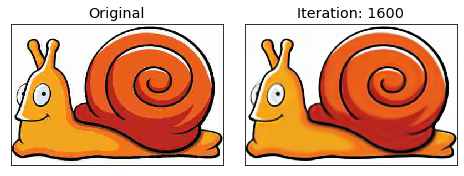

Iteration  1700   Loss = 0.002442   PSNR noisy = 26.122593   PSNR gt = 26.122593 
Iteration  1800   Loss = 0.002182   PSNR noisy = 26.611822   PSNR gt = 26.611822 


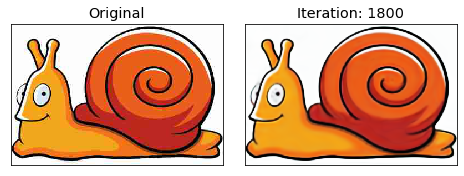

Iteration  1900   Loss = 0.002113   PSNR noisy = 26.750920   PSNR gt = 26.750920 
Iteration  2000   Loss = 0.002189   PSNR noisy = 26.596668   PSNR gt = 26.596668 


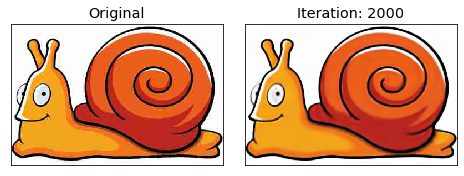

Iteration  2100   Loss = 0.002139   PSNR noisy = 26.698274   PSNR gt = 26.698274 
Iteration  2200   Loss = 0.002101   PSNR noisy = 26.776042   PSNR gt = 26.776042 


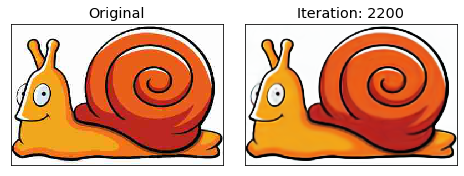

Iteration  2300   Loss = 0.002266   PSNR noisy = 26.447840   PSNR gt = 26.447840 
Done training final Loss = 0.0023319274187088013   PSNR = 26.322849854937644   PSNR gt = 26.322849854937644


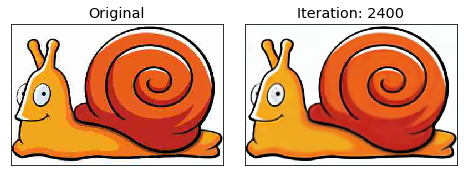

In [6]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
LR = 0.01
num_iter = 2400
show_every = 100
optimizer = torch.optim.Adam(parameters, lr=LR)
psnr_noisy_res = []
psnr_gt_res = []
losses_res = []
for i in range(num_iter):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out, target_noisy_img)
    loss.backward()
    psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0])
    psnr_gt = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    psnr_noisy_res.append(psnr_noisy)
    psnr_gt_res.append(psnr_gt)
    losses_res.append(loss.item())
    # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])
    optimizer.step()
    print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {i}'])
print(f'Done training final Loss = {loss.item()}   PSNR = {psnr_noisy}   PSNR gt = {psnr_gt}')
fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'])


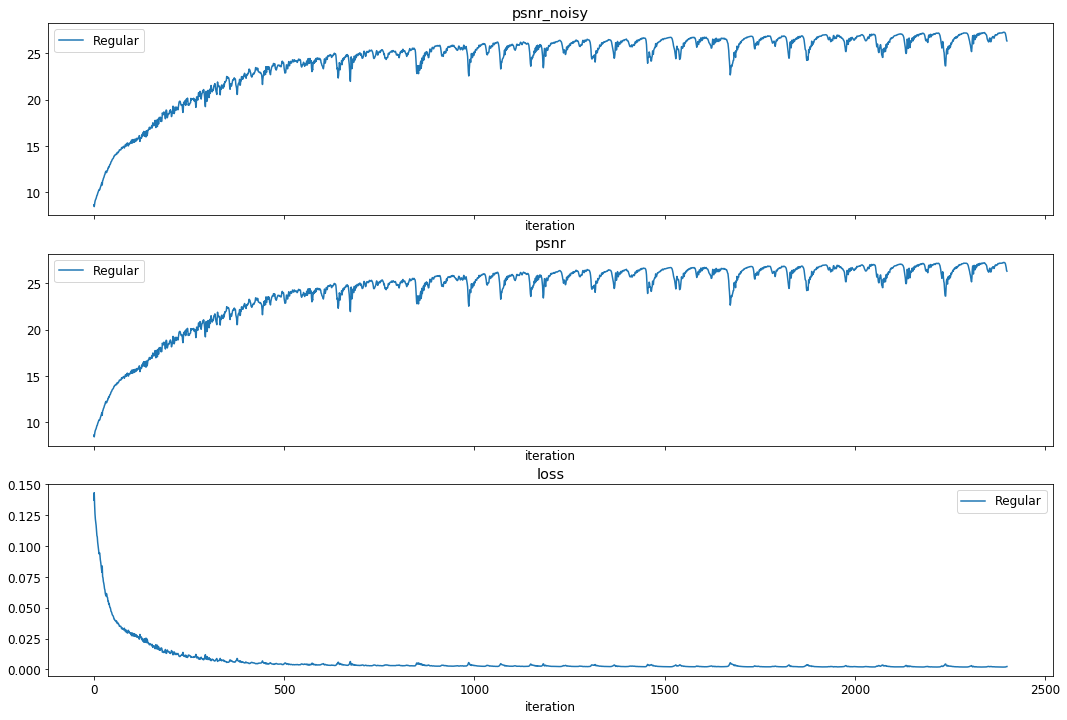

In [7]:
def plot_experiment_results(results, exp_name, fig=None):
    if fig is None:
        fig, _ = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18,12))
    for i, plot_type in enumerate(('psnr_noisy', 'psnr', 'loss')):
        ax = fig.axes[i]
        if plot_type not in results:
            continue
        exp_res = results[plot_type]    
        ax.plot(list(range(len(exp_res))), exp_res, label=exp_name)
        ax.set_title(plot_type)
        ax.set_xlabel('iteration')
        ax.legend()
    return fig
    
experiments_results_fig = plot_experiment_results({'psnr': psnr_gt_res, 'psnr_noisy': psnr_noisy_res, 'loss': losses_res}, 'Regular')

C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


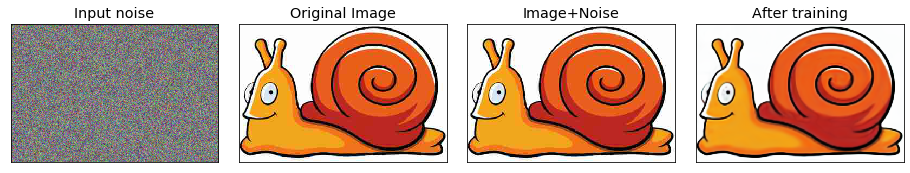

In [8]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([original_noise.squeeze(dim=0), img_tr, target_noisy_img.squeeze(dim=0), output], 
                                        titles=['Input noise', 'Original Image', 'Image+Noise', 'After training'],
                                        figsize=(16,16))
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}.png')
    regular_trained_output = output

# Regular Training with input optimization

In [9]:
if IMAGE == 'snail':
    net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1], weight_std=1./30).type(dtype)
elif IMAGE == 'jet':
    net = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30).type(dtype)
else:
    assert False
net.to(device)

new_input = net_input.clone().detach()

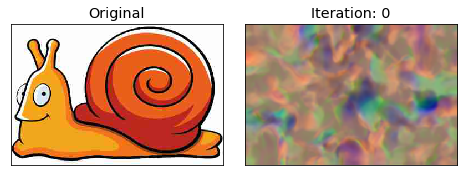

Iteration  100   Loss = 0.028019   PSNR noisy = 15.525474   PSNR gt = 15.525474 
Iteration  200   Loss = 0.012357   PSNR noisy = 19.081002   PSNR gt = 19.081002 


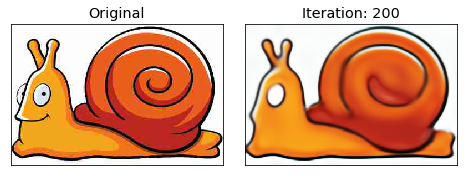

Iteration  300   Loss = 0.007784   PSNR noisy = 21.088066   PSNR gt = 21.088066 
Iteration  400   Loss = 0.005893   PSNR noisy = 22.296722   PSNR gt = 22.296722 


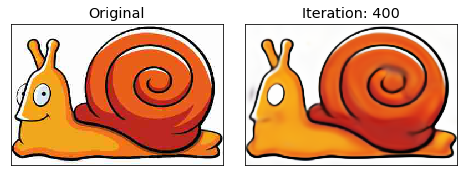

Iteration  500   Loss = 0.003961   PSNR noisy = 24.022401   PSNR gt = 24.022401 
Iteration  600   Loss = 0.003467   PSNR noisy = 24.600984   PSNR gt = 24.600984 


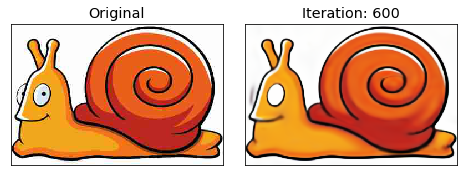

Iteration  700   Loss = 0.003276   PSNR noisy = 24.846612   PSNR gt = 24.846612 
Iteration  800   Loss = 0.002884   PSNR noisy = 25.399845   PSNR gt = 25.399845 


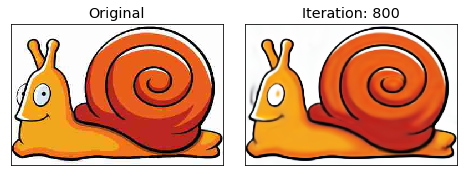

Iteration  900   Loss = 0.002816   PSNR noisy = 25.504174   PSNR gt = 25.504174 
Iteration  1000   Loss = 0.002544   PSNR noisy = 25.944409   PSNR gt = 25.944409 


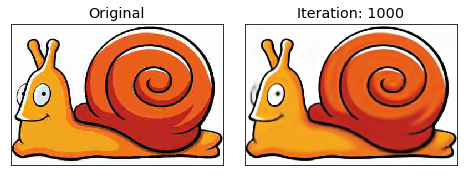

Iteration  1100   Loss = 0.002426   PSNR noisy = 26.150263   PSNR gt = 26.150263 
Iteration  1200   Loss = 0.002288   PSNR noisy = 26.404748   PSNR gt = 26.404748 


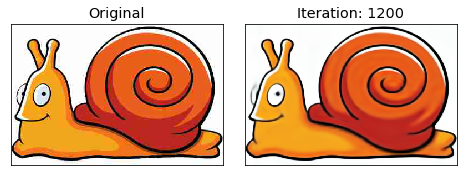

Iteration  1300   Loss = 0.002419   PSNR noisy = 26.164034   PSNR gt = 26.164034 
Iteration  1400   Loss = 0.002399   PSNR noisy = 26.199800   PSNR gt = 26.199800 


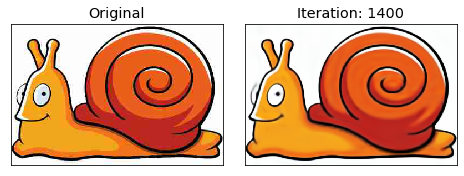

Iteration  1500   Loss = 0.002111   PSNR noisy = 26.754790   PSNR gt = 26.754790 
Iteration  1600   Loss = 0.002469   PSNR noisy = 26.075276   PSNR gt = 26.075276 


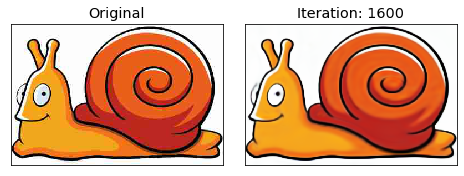

Iteration  1700   Loss = 0.002417   PSNR noisy = 26.167803   PSNR gt = 26.167803 
Iteration  1800   Loss = 0.002009   PSNR noisy = 26.969211   PSNR gt = 26.969211  


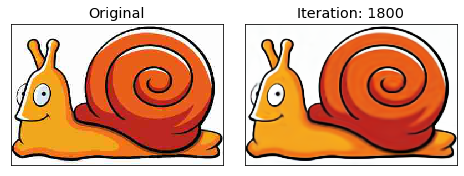

Iteration  1900   Loss = 0.002007   PSNR noisy = 26.975147   PSNR gt = 26.975147 
Iteration  2000   Loss = 0.002002   PSNR noisy = 26.985394   PSNR gt = 26.985394 


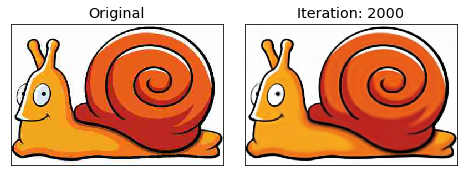

Iteration  2100   Loss = 0.002087   PSNR noisy = 26.804001   PSNR gt = 26.804001 
Iteration  2200   Loss = 0.001918   PSNR noisy = 27.171809   PSNR gt = 27.171809 


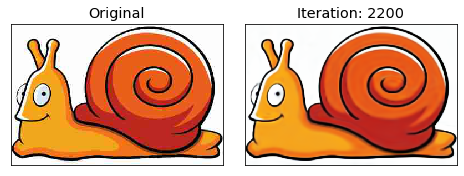

Iteration  2300   Loss = 0.001994   PSNR noisy = 27.002550   PSNR gt = 27.002550 
Done training final Loss = 0.0019695654045790434   PSNR = 27.0562958154922   PSNR gt = 27.0562958154922


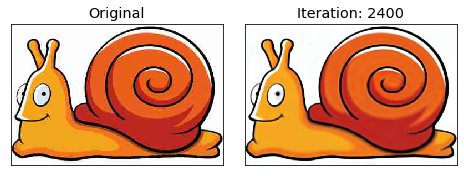

In [10]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
LR = 0.01
num_iter = 2400
show_every = 100
optimizer = torch.optim.Adam(parameters, lr=LR)
input_optimizer = torch.optim.Adam([new_input.requires_grad_()], lr=LR)
in_opt_psnr_noisy_res = []
in_opt_psnr_gt_res = []
in_opt_losses_res = []
for i in range(num_iter):
    optimizer.zero_grad()
    input_optimizer.zero_grad()
    out = net(new_input)
    loss = mse(out, target_noisy_img)
    loss.backward()
    psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0])
    psnr_gt = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])
    optimizer.step()
    input_optimizer.step()
    in_opt_psnr_noisy_res.append(psnr_noisy)
    in_opt_psnr_gt_res.append(psnr_gt)
    in_opt_losses_res.append(loss.item())
    print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {i}'])
print(f'Done training final Loss = {loss.item()}   PSNR = {psnr_noisy}   PSNR gt = {psnr_gt}')
fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'])

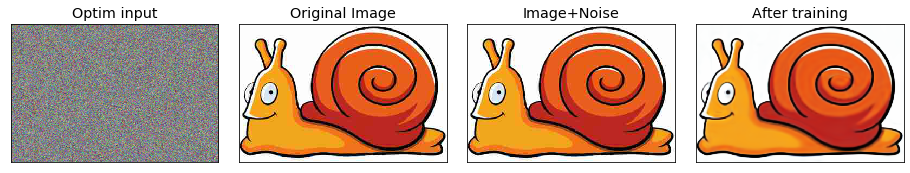

In [14]:
# Showing result of the training using original noise
with torch.no_grad():
    optimized_noise = new_input
    output = net(optimized_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([optimized_noise.squeeze(dim=0).detach(), img_tr, target_noisy_img.squeeze(dim=0), output], 
                                        titles=['Optim input', 'Original Image', 'Image+Noise', 'After training'],
                                        figsize=(16,16))
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}_input_optimization.png')
    input_optimized_trained_output = output

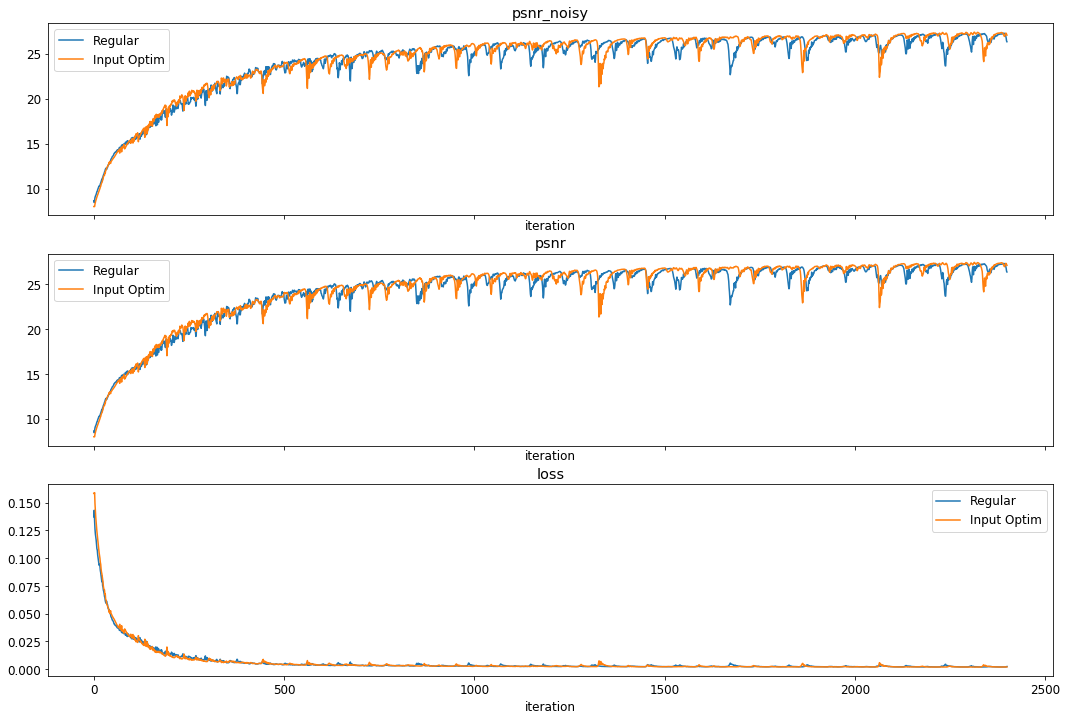

In [16]:
experiments_results_fig = plot_experiment_results({'psnr': psnr_gt_res, 'psnr_noisy': psnr_noisy_res, 'loss': losses_res}, 'Regular')
experiments_results_fig = plot_experiment_results({'psnr': in_opt_psnr_gt_res, 'psnr_noisy': in_opt_psnr_noisy_res, 'loss': in_opt_losses_res}, 'Input Optim', fig=experiments_results_fig);

# Adversarial Training

In [17]:
from models.adverserialModel import *

# Models
if IMAGE == 'snail':
    gen = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1], weight_std=1./30)
elif IMAGE == 'jet':
    gen = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
else:
    assert False
    
gen.to(device)
# gen = net 
dsc = Discriminator(img_tr.shape).to(device)

# Hyperparams
DSC_LR = 0.01
GEN_LR = 0.01
DATA_LABEL = 1
LABEL_NOISE = 0.3
num_iter = 2000

# Optimizers
dsc_optimizer = torch.optim.Adam(dsc.parameters(), DSC_LR)
gen_optimizer = torch.optim.Adam(gen.parameters(), GEN_LR)

# Loss
def dsc_loss_fn(y_data, y_generated):
    return discriminator_loss_fn(y_data, y_generated, DATA_LABEL, LABEL_NOISE)

def gen_loss_fn(y_generated):
    return generator_loss_fn(y_generated, DATA_LABEL)

# Gen input
# net_input = get_noise(input_depth, *img_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
# noise = net_input.detach().clone()
# if reg_noise_std > 0:
#         net_input = net_input + (noise.normal_() * reg_noise_std)

C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


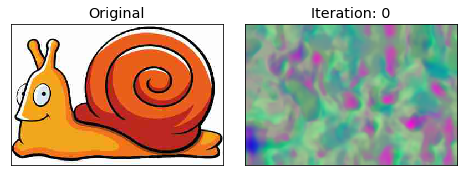

Iteration  100   Gen Loss = 558.742859   Dsc Loss = 252.205048   PSNR noisy = 6.352105   PSNR = 6.352105   
Iteration  200   Gen Loss = 1220.277100   Dsc Loss = -135.755249   PSNR noisy = 7.557543   PSNR = 7.557543 


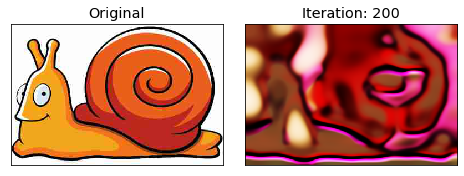

Iteration  300   Gen Loss = 1537.736816   Dsc Loss = 151.829102   PSNR noisy = 11.267607   PSNR = 11.267607  


KeyboardInterrupt: 

In [18]:
# Training loop
adv_psnr_noisy_res = []
adv_psnr_gt_res = []
for i in range(num_iter):
    dsc_loss, gen_loss, output = train_batch(dsc, gen, dsc_loss_fn, gen_loss_fn,
                                    dsc_optimizer, gen_optimizer,
                                    target_noisy_img, net_input)
    psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                         output.detach().cpu().numpy()[0])
    psnr_gt = peak_signal_noise_ratio(img_np, output.detach().cpu().numpy()[0]) 
    adv_psnr_noisy_res.append(psnr_noisy)
    adv_psnr_gt_res.append(psnr_gt)
    print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR noisy = %06f   PSNR = %06f' % 
          (i, gen_loss, dsc_loss, psnr_noisy, psnr_gt), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR noisy = %06f   PSNR = %06f' % 
              (i, gen_loss, dsc_loss, psnr_noisy, psnr_gt))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([img_tr, output[0].detach()], 
                                      titles=['Original', f'Iteration: {i}'], cmap='Greys')
    

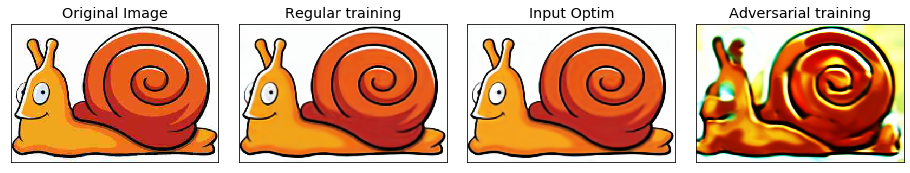

In [20]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = net_input
    output = gen(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, regular_trained_output, input_optimized_trained_output, output], 
                                        titles=['Original Image', 'Regular training', 'Input Optim', 'Adversarial training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/restoration/{IMAGE}_adversarial.png')

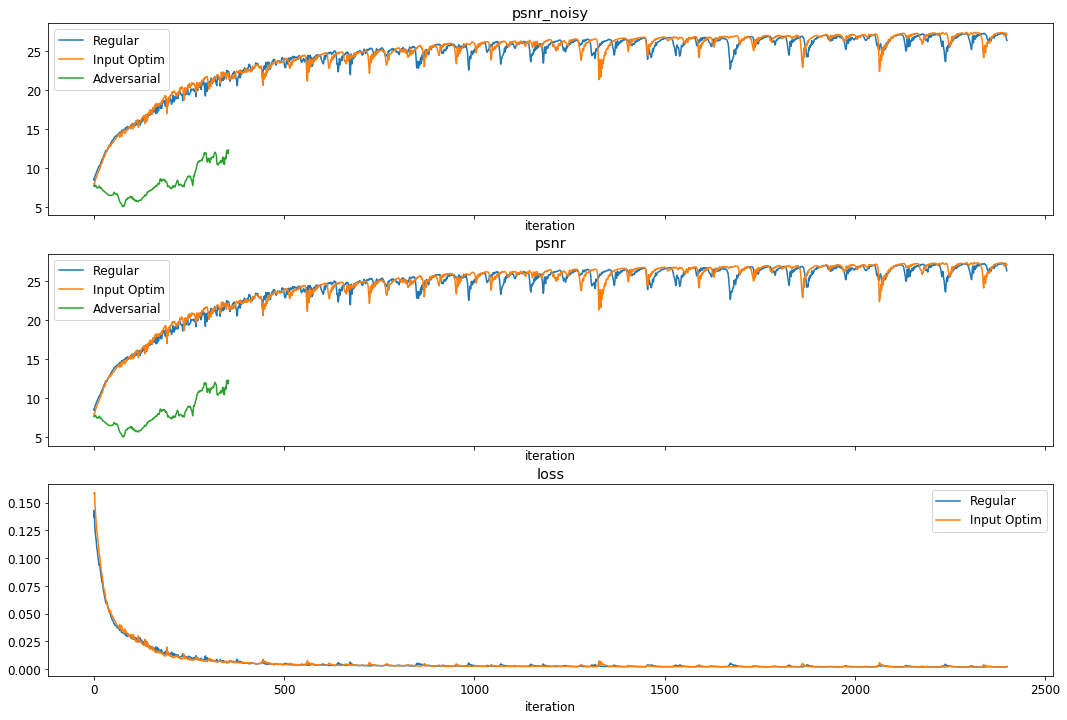

In [21]:
plot_experiment_results({'psnr': adv_psnr_gt_res, 'psnr_noisy': adv_psnr_noisy_res}, 'Adversarial', fig=experiments_results_fig)